In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, coo_matrix
from jax.experimental import sparse
import jax.numpy as jnp
import jax.random as random
from jax import lax, vmap
import jax

import scipy.optimize as opt

from scipy.fft import fft2, ifft2, fftshift



In [2]:
savefig_args = {
    'transparent': True,
    'format': 'pdf',
    'dpi': 300,
    'facecolor': 'none',
    'bbox_inches': 'tight',
    'pad_inches': 0
}
#mm to inches conversion
def mm_to_inches(mm):
    return mm / 25.4

In [3]:
# exponential correlation function
def C_exponential(x,xi):
    """
        Exponential correlation function

        Parameters
        x : np.array
            Array of distance vectors (x1,x2,...,xn) of shape (N,d)
        xi : float
            Correlation length

    """
    # make sure this also works for d=1
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    return np.exp(-np.linalg.norm(x, axis=1)/xi)

In [5]:
def correlated_disorder(L,xi, seed=1000):
    
    """
        Generate two correlated Gaussian random fields with exponential correlation restrain in the interval [0,1]
        Parameters:
        L (int): The size of the grid (L+1 x L+1).
        xi (float): The correlation length.
        Returns:
        tuple: Two 2D numpy arrays representing the correlated Gaussian random fields.
    """

    x = np.arange(-L//2, L//2 + 1)
    y = np.arange(-L//2, L//2 + 1)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
   
    Cx = C_exponential(coords, xi).reshape(L+1, L+1)
    Ck_2d = np.fft.fft2(Cx)
    k_2d = np.fft.fftfreq(Cx.shape[0], d=1)
    Sk_2d = np.abs(Ck_2d)
    np.random.seed(seed)
    Gk_2d = np.random.normal(0, 1, Ck_2d.shape) * np.sqrt(Sk_2d)
    # inverse Fourier transform gives two real-valued Gaussian random fields (real and imaginary part)
    Gx_2d = np.fft.ifft2(Gk_2d)
    Gx1_2d = np.real(Gx_2d)
    Gx2_2d = np.imag(Gx_2d)
    Gx1_2d=Gx1_2d-np.min(Gx1_2d)
    Gx1_2d=Gx1_2d*1/np.max(Gx1_2d)
    Gx2_2d=Gx2_2d-np.min(Gx2_2d)
    Gx2_2d=Gx2_2d*1/np.max(Gx2_2d)
    
    return Gx1_2d,Gx2_2d
    

In [6]:
def find_threshold_for_ratio(G, p, tol=1e-5):
    """
    Find the threshold value for which the ratio of elements in G less than the threshold
    is approximately equal to p.

    Parameters:
    G : np.ndarray
        The input array.
    p : float
        The desired ratio.
    tol : float
        The tolerance for the ratio.

    Returns:
    float
        The threshold value.
    """
    low, high = np.min(G), np.max(G)
    while high - low > tol:
        mid = (low + high) / 2
        ratio = np.sum(G < mid) / G.size
        if ratio < p:
            low = mid
        else:
            high = mid
    return (low + high) / 2

In [66]:

def generate_laplacian(N, conduction_block_threshold,xi, sparse_matrix=False):
    """
    Generate the Laplacian matrix for a grid graph with conduction blocks given by correlated disorder.
    parameters:
    N : int
        The size of the grid (N x N).
    conduction_block_threshold : float in [0, 1]
        The threshold for conduction blocks.
    xi : float
        The correlation length of the disorder.
    sparse_matrix : bool
        Whether to return a sparse matrix.
    returns:
    scipy.sparse.coo_matrix or np.ndarray
        The Laplacian matrix.
    np.ndarray
        The conduction blocks.  
    """
    num_nodes = N * N
    adj_rows = []
    adj_cols = []
    adj_data = []
    Gx, G2=correlated_disorder(N-1,xi)

    conduction_blocks = Gx.reshape(N, N) < find_threshold_for_ratio(Gx, conduction_block_threshold)


    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * N + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(N)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < N)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks



In [8]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

In [83]:

L1, c1= generate_laplacian(200, 0.01, 10, sparse_matrix=True)
c1=np.array(c1)

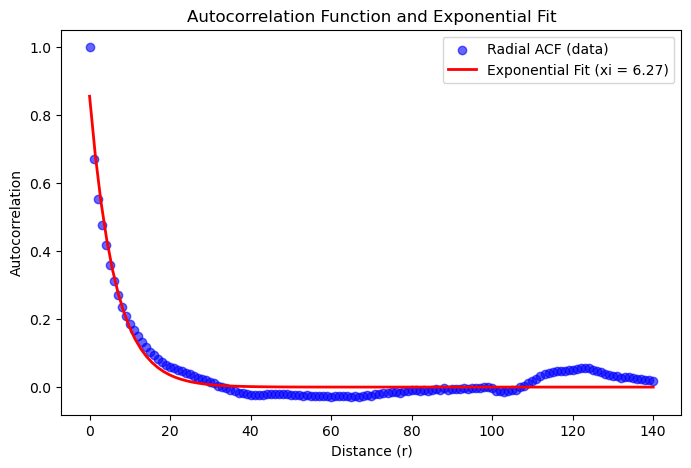

Fitted parameters: C0 = 0.856, xi = 6.272


In [33]:


def compute_autocorrelation(matrix):
    """Compute the autocorrelation function (ACF) using FFT."""
    matrix = matrix.astype(np.float64)
    matrix -= np.mean(matrix)  # Zero mean
    
    # Compute FFT-based autocorrelation
    fft_matrix = fft2(matrix)
    power_spectrum = np.abs(fft_matrix) ** 2
    autocorr = np.real(ifft2(power_spectrum))
    autocorr = fftshift(autocorr)  # Center the ACF
    
    # Normalize ACF
    autocorr /= autocorr.max()
    return autocorr

def radial_profile(acf):
    """Compute the radial average of the autocorrelation function."""
    ny, nx = acf.shape
    y, x = np.indices((ny, nx))
    center = np.array([ny // 2, nx // 2])
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Bin ACF values by distance
    r = r.flatten()
    acf_values = acf.flatten()
    
    r_bins = np.arange(0, np.max(r), 1)
    acf_radial = np.array([acf_values[(r >= r_bins[i]) & (r < r_bins[i+1])].mean()
                           for i in range(len(r_bins)-1)])
    
    return r_bins[:-1], acf_radial  # Return distances and ACF values

def exponential_fit(r, C0, xi):
    """Exponential decay model for fitting."""
    return C0 * np.exp(-r / xi)

def fit_correlation_length(matrix):
    """Compute the correlation length by fitting an exponential to the ACF."""
    acf = compute_autocorrelation(matrix)
    r, acf_r = radial_profile(acf)
    
    # Fit exponential decay function to the ACF
    valid = ~np.isnan(acf_r) & (acf_r > 0)  # Remove NaNs and negative values
    popt, _ = opt.curve_fit(exponential_fit, r[valid], acf_r[valid], p0=[1, 10])
    
    return r, acf_r, popt  # Return distances, ACF values, and fit parameters

def plot_fit(matrix):
    """Plot the ACF data and its exponential fit."""
    r, acf_r, popt = fit_correlation_length(matrix)
    C0, xi = popt
    
    # Generate fit curve
    r_fit = np.linspace(0, np.max(r), 100)
    acf_fit = exponential_fit(r_fit, C0, xi)
    
    # Plot results
    plt.figure(figsize=(8, 5))
    plt.scatter(r, acf_r, label="Radial ACF (data)", color="blue", alpha=0.6)
    plt.plot(r_fit, acf_fit, label=f"Exponential Fit (xi = {xi:.2f})", color="red", linewidth=2)
    #plt.axhline(y=np.exp(-1), color='gray', linestyle='--', label="1/e threshold")
    plt.xlabel("Distance (r)")
    plt.ylabel("Autocorrelation")
    plt.legend()
    plt.title("Autocorrelation Function and Exponential Fit")

    plt.show()

# Example usage:
if __name__ == "__main__":
    
    plot_fit(c1)
    r, acf_r, popt = fit_correlation_length(c1)
    C0, xi = popt
    print(f"Fitted parameters: C0 = {C0:.3f}, xi = {xi:.3f}")


In [44]:
u_sol, v_sol = run_simulation(N=200*200, sigma=0.0001,L=L1, c1=c1,Du=0.04, a=3, key=random.PRNGKey(2),delta_t=0.1, total_time=7800, stimulus_time=1300, Nconf=1000)

In [ ]:

fig, axs = plt.subplots(1,11,figsize=(30,4))
min = -np.abs(u_sol).max()
max = u_sol.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(u_sol[int((i/len(axs)*7800)),:].reshape(200,200),cmap='seismic', interpolation='bilinear', vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])

In [11]:
from matplotlib.animation import FuncAnimation, PillowWriter

def create_movie_from_array(array, output_file="movie.mp4", fps=10, frame_skip=5):
    """
    Create a movie from a 3D array of shape (N, N, T).

    Parameters:
        array (numpy.ndarray): Input array of shape (N, N, T).
        output_file (str): Filename for the output movie (e.g., movie.gif).
        fps (int): Frames per second for the movie.
        frame_skip (int): Number of frames to skip to speed up the movie.
    """
    N, _, T = array.shape  # Extract dimensions
    fig, ax = plt.subplots(figsize=(6, 6)) 

    
    # Display the first frame
    img = ax.imshow(array[:, :, 0], cmap="seismic", interpolation="bilinear", vmin=-np.max(np.abs(array)), vmax=np.max(np.abs(array)), aspect='auto')
    #plt.axis("off")
    
    # Add a colorbar with specific ticks
    #cbar = fig.colorbar(img, ax=ax, ticks=[-0.9, -0.5, 0, 0.5, 0.9])
    
    #cbar.set_label('V', rotation=0, labelpad=15, fontsize=12, color='black')
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  
    
    # Update function for the animation
    def update(frame):
        img.set_data(array[:, :, frame])
        return img,

    # Create the animation with skipped frames
    frames = range(0, T, frame_skip)
    anim = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=True)
    
    # Save as GIF or MP4
    if output_file.endswith(".gif"):
        anim.save(output_file, writer=PillowWriter(fps=fps))
    elif output_file.endswith(".mp4"):
        anim.save(output_file, writer="ffmpeg", fps=fps)
    else:
        raise ValueError("Output file must end with .gif or .mp4")
    
    plt.close(fig)
    print(f"Movie saved to {output_file}")




In [45]:
u_sol=u_sol.T
u_sol4=u_sol.reshape(200,200, -1)

#u_sol3=u_sol2[12:(N_x-40),4:(N_x-4),:]


create_movie_from_array(u_sol4, output_file="./data/simulation_xi=10_p=0.45_seed=1000.gif", fps=100, frame_skip=1)

Movie saved to ./data/simulation_xi=10_p=0.45_seed=1000.gif


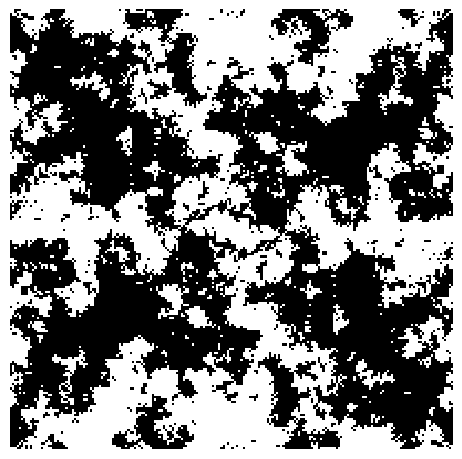

In [46]:
plt.figure(figsize=(mm_to_inches(145), mm_to_inches(145)))
plt.imshow(c1, cmap='gray', interpolation='none', aspect='auto')
plt.axis('off')
plt.savefig('./data/conduction_blocks_xi=10_p=0.45_seed=1000.pdf', **savefig_args)

## With error functions

In [4]:
from scipy.special import erfcinv


def compute_theta(p, sigma_tau=1):
    """
    Computes theta given probability p and standard deviation sigma_tau.
    
    Parameters:
        p (float): Probability value (0 < p < 1).
        sigma_tau (float): Standard deviation.
        
    Returns:
        float: Corresponding theta value.
    """
    if not (0 < p < 1):
        raise ValueError("p must be in the range (0,1)")
    
    return erfcinv(2 * p) * np.sqrt(2 * sigma_tau**2)


In [91]:


def separate_real_imag(arr: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Separates the real and imaginary parts of a complex numpy ndarray
    without using np.real and np.imag.

    Parameters:
    arr (np.ndarray): Input complex numpy array.

    Returns:
    tuple[np.ndarray, np.ndarray]: Tuple containing real and imaginary parts as separate numpy arrays.
    """
    real_part = (arr + arr.conj()) / 2
    imag_part = (arr - arr.conj()) / (2j)
    
    return real_part, imag_part


In [109]:


def correlated_disorder(L, xi, seed=1000):
    """
        Generate two correlated Gaussian random fields with exponential correlation restrain in the interval [0,1]
        Parameters:
        L (int): The size of the grid (L+1 x L+1).
        xi (float): The correlation length.
        Returns:
        tuple: Two 2D numpy arrays representing the correlated Gaussian random fields.
    """
    # Ensure L is even
    if L % 2 != 0:
        L += 1

    x = np.arange(-L//2, L//2 + 1)
    y = np.arange(-L//2, L//2 + 1)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
   
    Cx = C_exponential(coords, xi).reshape(x.size,y.size)
    Ck_2d = np.fft.fft2(Cx)
    k_2d = np.fft.fftfreq(Cx.shape[0], d=1)
    Sk_2d = np.abs(Ck_2d)
    np.random.seed(seed)
    Gk_2d = np.random.normal(0, 1, Ck_2d.shape) * np.sqrt(Sk_2d)*(L+1)*np.sqrt(2)
    # inverse Fourier transform gives two real-valued Gaussian random fields (real and imaginary part)
    Gx_2d = np.fft.ifft2(Gk_2d)
    Gx1_2d = np.real(Gx_2d)
    Gx2_2d = np.imag(Gx_2d)
    #Gx1_2d, Gx2_2d = separate_real_imag(Gx_2d)
    
    return Gx1_2d,Gx2_2d
    

(200,)


Text(0.5, 1.0, 'Power spectral density')

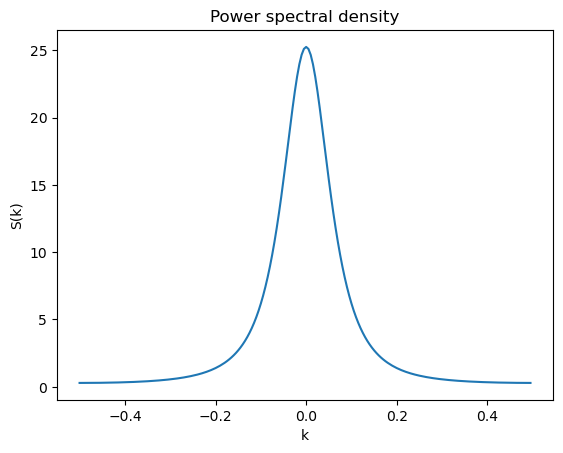

In [105]:

L=200
xi=2
x = np.arange(-L//2, L//2)
print(x.shape)
y = np.arange(-L//2, L//2 )
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
   
Cx = C_exponential(coords, xi).reshape(x.size, y.size)
Ck_2d = np.fft.fft2(Cx)
k_2d = np.fft.fftfreq(Cx.shape[0], d=1)
Sk_2d = np.abs(Ck_2d)

k_, Sk_ = zip(*sorted(zip(k_2d, Sk_2d[0])))
plt.plot(k_, Sk_)
plt.xlabel('k')
plt.ylabel('S(k)')
plt.title('Power spectral density')

Text(0.5, 1.0, 'Power spectral density')

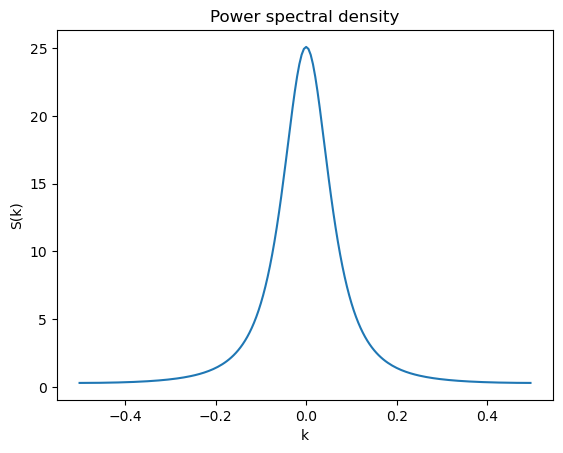

In [106]:
k_, Sk_ = zip(*sorted(zip(k_2d, Sk_2d[1])))
plt.plot(k_, Sk_)
plt.xlabel('k')
plt.ylabel('S(k)')
plt.title('Power spectral density')

In [107]:
np.random.seed(1000)
Gk_2d = np.random.normal(0, 1, Ck_2d.shape) * np.sqrt(Sk_2d)*(L+1)*np.sqrt(2)
# inverse Fourier transform gives two real-valued Gaussian random fields (real and imaginary part)
Gx_2d = np.fft.ifft2(Gk_2d)
#Gx1_2d = np.real(Gx_2d)
#Gx2_2d = np.imag(Gx_2d)
Gx1_2d, Gx2_2d = separate_real_imag(Gx_2d)
print(np.min(Gx1_2d), np.max(Gx1_2d))
print(np.min(Gx2_2d), np.max(Gx2_2d))

(-4.22420270974743+0j) (4.188620006486192+0j)
(-4.554393992653533-0j) (4.554393992653533+0j)


c:\Users\pelli\anaconda3\lib\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
c:\Users\pelli\anaconda3\lib\site-packages\numpy\lib\histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
c:\Users\pelli\anaconda3\lib\site-packages\matplotlib\transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


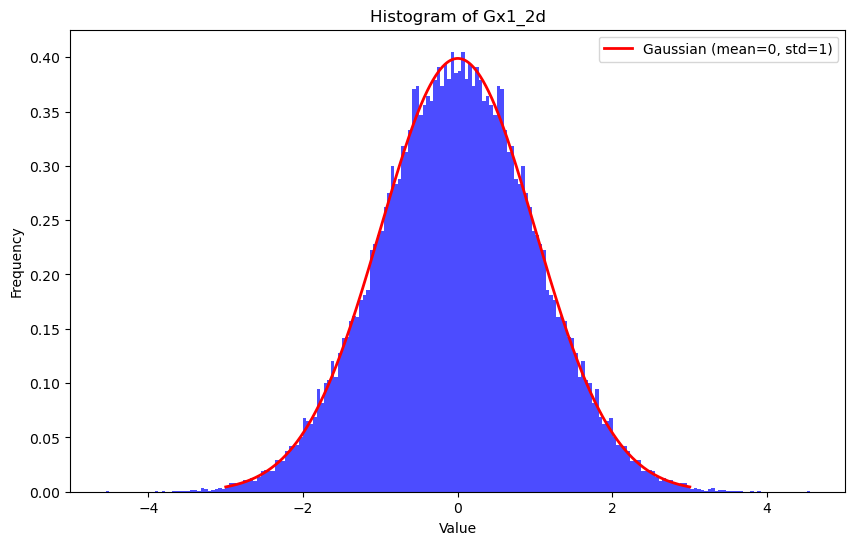

In [108]:
plt.figure(figsize=(10, 6))
#Gk_2d = Gk_2d / L  # Normalize Gk_2d to have values between -3 and 3 approximately
plt.hist(Gx2_2d.flatten(), bins=200, color='blue', alpha=0.7, density=True)

# Plot Gaussian with std of 1 and mean 0
x = np.linspace(-3, 3, 1000)
sigma=1
gaussian = (1 / (sigma*np.sqrt(2 * np.pi))) * np.exp(-0.5 * x**2/sigma**2)
plt.plot(x, gaussian, color='red', linewidth=2, label='Gaussian (mean=0, std=1)')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Gx1_2d')
plt.legend()
plt.show()


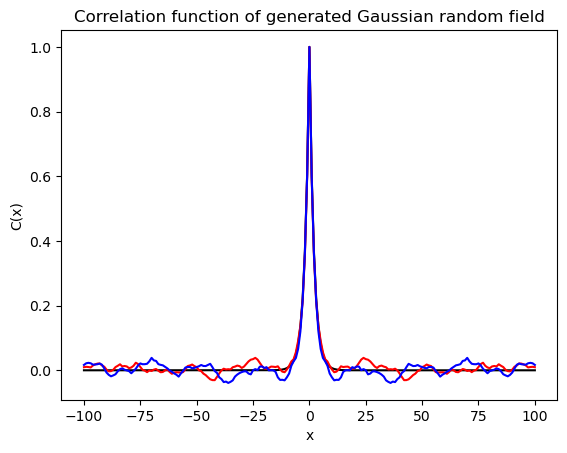

In [14]:

from scipy.signal import correlate2d

Cx1 = correlate2d(Gx1_2d, Gx1_2d, mode='same')
Cx2 = correlate2d(Gx2_2d, Gx2_2d, mode='same')
# normalize
Cx1 = Cx1 / Cx1[int(len(Cx1)/2), int(len(Cx1)/2)]
Cx2 = Cx2 / Cx2[int(len(Cx2)/2), int(len(Cx2)/2)]
# plot the correlation function of the generated Gaussian random field
plt.plot(x, Cx[int(len(Cx)/2)], c='k')
plt.plot(x, Cx1[int(len(Cx1)/2)], c='r')
plt.plot(x, Cx2[int(len(Cx2)/2)], c='b')
plt.xlabel('x')
plt.ylabel('C(x)')
plt.title('Correlation function of generated Gaussian random field')
plt.show()

In [22]:

def generate_laplacian(N, conduction_block_threshold,xi, sparse_matrix=False):
    """
    Generate the Laplacian matrix for a grid graph with conduction blocks given by correlated disorder.
    parameters:
    N : int
        The size of the grid (N x N).
    conduction_block_threshold : float in [0, 1]
        The threshold for conduction blocks.
    xi : float
        The correlation length of the disorder.
    sparse_matrix : bool
        Whether to return a sparse matrix.
    returns:
    scipy.sparse.coo_matrix or np.ndarray
        The Laplacian matrix.
    np.ndarray
        The conduction blocks.  
    """
    num_nodes = N * N
    adj_rows = []
    adj_cols = []
    adj_data = []
    Gx, G2=correlated_disorder(N-1,xi)

    conduction_blocks = Gx.reshape(N, N) < compute_theta(conduction_block_threshold)


    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * N + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(N)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < N)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks



In [25]:
Gx, G2=correlated_disorder(200-1,10)

In [26]:
print(np.min(Gx), np.max(Gx))

-2.680826835415856 2.684724444457318


In [28]:
sigma = np.std(Gx)  # Standard deviation of the correlated field
print(sigma)


0.6752127218447976


In [30]:
print(compute_theta(0.45, sigma_tau=1))

0.12566134685507405


In [37]:
L1, c1= generate_laplacian(200, 0.45, 6, sparse_matrix=True)

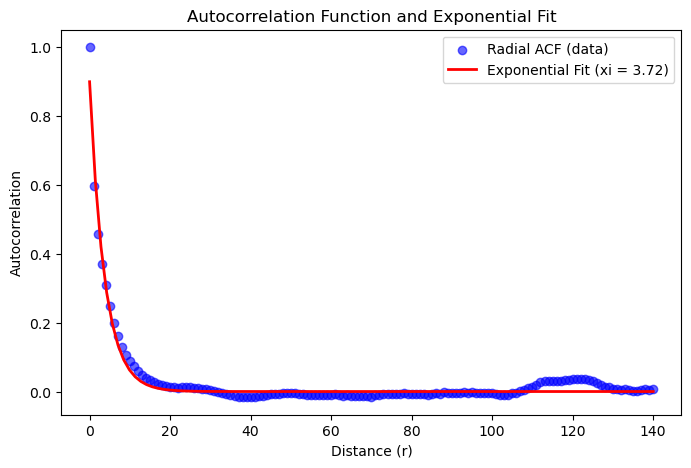

Fitted parameters: C0 = 0.900, xi = 3.720


In [38]:
c1=np.array(c1)
plot_fit(c1)
r, acf_r, popt = fit_correlation_length(c1)
C0, xi = popt
print(f"Fitted parameters: C0 = {C0:.3f}, xi = {xi:.3f}")

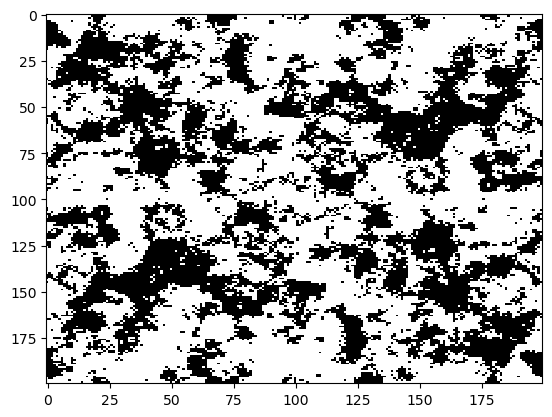

In [40]:
plt.imshow(c1, cmap='gray', interpolation='none', aspect='auto')